In [13]:
import importlib
import pyspark.sql.functions as F
from pyspark.sql import Window
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import statsmodels.tsa.ar_model as ar_model
from sklearn.metrics import mean_absolute_error
import pandas as pd
import time
from numpy.fft import fft, ifft

# from trade_flow_modelling import data_downloader
# from trade_flow_modelling import data_loader
# from trade_flow_modelling import sign_extractor
from trade_flow_modelling.src.data_management.data_loader import data_loader
from trade_flow_modelling.src.data_management.data_downloader import data_downloader

import settings
from trade_flow_modelling.src.data_management.sign_extractor import sign_extractor
from modelisation.metrics import metric_calculator
from modelisation.time_series_modelling import autocorrelation_calculator
# from trade_flow_modelling.src.modelisation.metrics import metric_calculator
# from trade_flow_modelling.src.modelisation.sign_simulator import sign_simulator
# from trade_flow_modelling.src.modelisation.utils import pyspark_utils


%matplotlib inline

In [ ]:
importlib.reload(data_downloader)
data_downloader.download_data("APTUSDT", "daily", "2023-11-01", "2023-11-03")
# data_downloader.download_data("APTUSDT", "monthly", "2022-10", "2022-12")

In [3]:
# importlib.reload(data_loader)
data = data_loader.load_data("APTUSDT", "monthly", "2023-11", "2023-11")
# data = data_loader.load_data("BTCUSDT", "monthly", "2023-10", "2023-10")

# print(data.count())
# data.show(10)

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=25400Kb max_used=25605Kb free=105671Kb
 bounds [0x000000010a1e0000, 0x000000010bb10000, 0x00000001121e0000]
 total_blobs=9739 nmethods=8778 adapters=874
 compilation: disabled (not enough contiguous free space left)


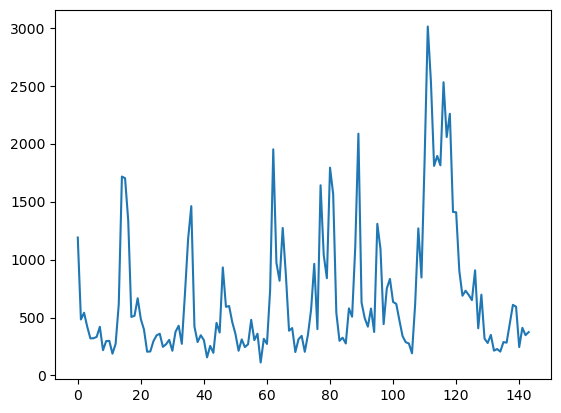

In [ ]:
from trade_flow_modelling.src.modelisation.utils import pyspark_utils

def day_number_as_string(day_number):
    if (day_number >= 1 and day_number <= 9):
        return f"0{day_number}"
    else:
        return f"{day_number}"
    
for i in range(1, 10):
    window = F.window("date_time", "10 minutes").alias("time_window")
    nb_trades_per_bin = data.filter(F.col("date") == f"202311{day_number_as_string(i)}").groupBy(window).agg(F.count("id").alias("nb_trades")).sort("time_window")
    # nb_trades_per_bin.show(100, truncate=False)

    trades = pyspark_utils.get_column_from_pyspark_df(nb_trades_per_bin, column_name="nb_trades", sort_column="time_window")
    # print(len(trades), trades[:10])
    plt.plot(trades, label=f"{day_number_as_string(i)}")
plt.show()

In [ ]:
def percentage_buy_per_day(data):
    cnt_cond = lambda cond: F.sum(F.when(cond, 1).otherwise(0))
    
    nb_trades_expr = F.count("id").alias("nb_trades")
    pct_buy_expr = F.round(100 * cnt_cond(F.col("side") == "buy") / cnt_cond(F.col("side").isin(["buy", "sell"])), 2).alias("pct_buy")
    pct_buy = data.groupBy(F.col("date")).agg(nb_trades_expr, pct_buy_expr).sort("date")
    return pct_buy

buy_pct = percentage_buy_per_day(data)
buy_pct.show(100)

+--------+---------+-------+
|    date|nb_trades|pct_buy|
+--------+---------+-------+
|20230901|    79529|  50.99|
|20230902|    46090|   51.0|
|20230903|    34732|   50.5|
|20230904|    70789|  52.87|
|20230905|   129532|  50.58|
|20230906|   106644|  49.11|
|20230907|    64638|  51.52|
|20230908|    62435|  48.98|
|20230909|    25500|  47.29|
|20230910|   183349|  47.38|
|20230911|   148667|  48.99|
|20230912|   140802|  51.85|
|20230913|   131254|  51.41|
|20230914|   134383|  51.98|
|20230915|    82808|  49.29|
|20230916|    57493|  48.49|
|20230917|    41993|  50.12|
|20230918|   130244|  48.55|
|20230919|   211645|  21.88|
|20230920|    98759|  45.98|
|20230921|    98554|   44.5|
|20230922|    63414|  49.82|
|20230923|    30406|  46.55|
|20230924|    38377|  48.15|
|20230925|    52018|  48.27|
|20230926|    51826|   48.3|
|20230927|    69839|   48.3|
|20230928|    75243|  49.42|
|20230929|    79328|  46.44|
|20230930|   120229|  49.36|
|20231001|   250790|  48.98|
|20231002|   2

In [2]:
signs = sign_extractor.retrieve_signs("APTUSDT", "2023-11-01", "2023-11-01")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/05 17:42:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [51]:
importlib.reload(autocorrelation_calculator)
def plot_autocorrelation_np(time_series, nb_lags=None, label="Autocorrelation function", gamma=2.1, log_scale=True):
    fig, axe = plt.subplots(1, 1, figsize=(8, 4))
    autocorrelation = None
    if (nb_lags is None):
        autocorrelation = autocorrelation_calculator.autocorrelation_np(time_series)
    else:
        autocorrelation = autocorrelation_calculator.autocorrelation_convolution_perso(time_series, nb_lags)

    axe.plot(autocorrelation, "orange", label=label)

    x = [i for i in range(1, len(autocorrelation))]
    y_1 = [l ** (-0.5) if l > 0 else 1 for l in x]
    y_2 = [l ** (-1.9) if l > 0 else 1 for l in x]

    axe.plot(y_1, "grey", linestyle="dashed", label="x^(-0.5)")
    axe.plot(y_2, "brown", linestyle="dashed", label="x^(-1.9)")

    if (log_scale):
        axe.set_yscale("log")

    axe.set_title(f"Autocorrelation plot | {'log' if log_scale else 'linear'} scale")
    axe.set_xlabel("Lag")
    axe.set_ylabel("Autocorrelation")
    axe.set_xlim(-5, nb_lags)
    axe.set_ylim(max(0.001, np.nanmin(autocorrelation) - 0.1), np.nanmax(autocorrelation) + 0.1)
    axe.grid(True)
    axe.legend()
    plt.show()

AUTOCORRELATION


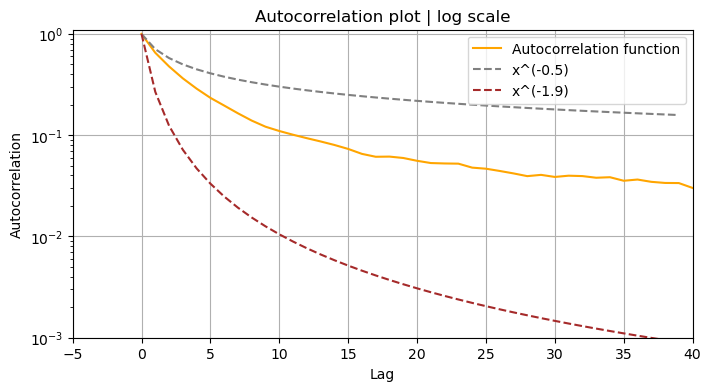

In [52]:
plot_autocorrelation_np(signs, 40)

In [38]:

N = 100000000
# arr = [np.random.normal() for i in range(N)]
arr = np.random.normal(size=N)

In [50]:

s = 0
s1 = time.time()
for i in arr:
    s += i
e1 = time.time()
print(s, e1-s1)

s = 0
s1 = time.time()
for i in range(len(arr)):
    temp = arr[i]
    s += temp
e1 = time.time()
print(s, e1-s1)

s = 0
s2 = time.time()
s = np.sum(arr)
e2 = time.time()
print(s, e2-s2)

s = 0
s2 = time.time()
s = sum(arr)
e2 = time.time()
print(s, e2-s2)

s = 0
s2 = time.time()
s = np.sum([i for i in arr])
e2 = time.time()
print(s, e2-s2)

7348.421742551142 10.966249942779541
7348.421742551142 17.15259289741516
7348.4217425475435 0.030214786529541016
7348.421742551142 6.348753929138184
7348.4217425475435 12.989444971084595


In [25]:
np.corrcoef(signs[3:], signs[:-3])

array([[1.        , 0.36398013],
       [0.36398013, 1.        ]])

V1 autocorrelation_np | 5.601 s
V2 autocorrelation_convolution_perso | 1.105 s
V2 Bis autocorrelation_convolution_perso_bis | 2.089 s
V2 Tris autocorrelation_convolution_perso_bis | 2.088 s
V3 autocorrelation_statistical_perso | 8.534 s
V4 acf_by_hand | 3.048 s
V5 autocorr_by_hand | 5.832 s
V6 fft_act | 0.009 s
V7 acf_corrcoef | 2.186 s
[1.0, 0.6514043195706954, 0.47730542037768187, 0.3639702506656873]
[1.0, 0.6514043195706954, 0.47730542037768187, 0.3639702506656873]
[1.0, 0.6514102942781463, 0.47731413848898635, 0.36398013009237284]
[1.0, 0.6514036670752844, 0.47730439923507534, 0.36396897958002616]
[1.0000000000000002, 0.6514036484876444, 0.47730439927312673, 0.3639689899370616]
[1.0, 0.6514043195706954, 0.47730542037768187, 0.3639702506656873]
[1.0, 0.6514102942429927, 0.47731413848977894, 0.3639801300261274]


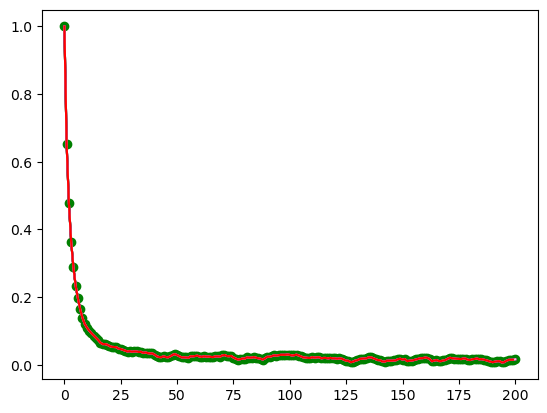

In [58]:
# V1
def autocorrelation_np(x, nb_lags=None):
    result = np.correlate(x, x, mode="full")
    if (nb_lags is not None):
        return result[result.size // 2:][:nb_lags + 1] / float(result.max())
    else:
        return result[result.size // 2:] / float(result.max())

# V2
def autocorrelation_convolution_perso(x, nb_lags=None):
    # assert(nb_lags is None or nb_lags < len(x))
    autocorrelation_coeffs = []
    range_upper_bound = (nb_lags + 1) if nb_lags is not None else len(x)
    for k in range(range_upper_bound):
        current_autocorrelation_coeff = autocorrelation_lag_k_convolution(x, k)
        autocorrelation_coeffs.append(current_autocorrelation_coeff)
    
    autocorrelation_coeffs = np.array(autocorrelation_coeffs)
    return np.array(autocorrelation_coeffs) / float(autocorrelation_coeffs.max())

def autocorrelation_lag_k_convolution(x, k):
    # assert(k < len(x))
    autocorrelation_lag_k_coeff = 0
    for i in range(len(x) - k):
        autocorrelation_lag_k_coeff += (x[i] * x[i + k])
    return autocorrelation_lag_k_coeff

# V2 bis
def autocorrelation_convolution_perso_bis(x, nb_lags=None):
    # assert(nb_lags is None or nb_lags < len(x))
    autocorrelation_coeffs = []
    range_upper_bound = (nb_lags + 1) if nb_lags is not None else len(x)
    for k in range(range_upper_bound):
        current_autocorrelation_coeff = autocorrelation_lag_k_convolution_bis(x, k)
        autocorrelation_coeffs.append(current_autocorrelation_coeff)
    
    autocorrelation_coeffs = np.array(autocorrelation_coeffs)
    return np.array(autocorrelation_coeffs) / float(autocorrelation_coeffs.max())

def autocorrelation_lag_k_convolution_bis(x, k):
    # assert(k < len(x))
    autocorrelation_lag_k_coeff = 0
    y1 = np.array(x[:len(x) - k])
    y2 = np.array(x[k:])
    autocorrelation_lag_k_coeff = np.sum(y1 * y2)
    return autocorrelation_lag_k_coeff

# V2 tris
def autocorrelation_convolution_perso_tris(x, nb_lags=None):
    # assert(nb_lags is None or nb_lags < len(x))
    autocorrelation_coeffs = []
    range_upper_bound = (nb_lags + 1) if nb_lags is not None else len(x)
    for k in range(range_upper_bound):
        current_autocorrelation_coeff = autocorrelation_lag_k_convolution_tris(x, k)
        autocorrelation_coeffs.append(current_autocorrelation_coeff)
    
    autocorrelation_coeffs = np.array(autocorrelation_coeffs)
    return np.array(autocorrelation_coeffs) / float(autocorrelation_coeffs.max())

def autocorrelation_lag_k_convolution_tris(x, k):
    # assert(k < len(x))
    autocorrelation_lag_k_coeff = 0
    y1 = x[:len(x) - k]
    y2 = x[k:]
    autocorrelation_lag_k_coeff = np.dot(y1, y2)
    return autocorrelation_lag_k_coeff

# V3
def autocorrelation_statistical_perso_lag_k(time_series, k, mean):
    up = 0
    down = 0
    for i in range(k, len(time_series)):
        up += ((time_series[i] - mean) * (time_series[i - k] - mean))
        down += ((time_series[i] - mean) ** 2)
    autocorrelation = up / down
    return autocorrelation

def autocorrelation_statistical_perso(time_series, nb_lags):
    mean = np.mean(time_series)
    autocorrelation_coeffs = []
    for k in range(nb_lags + 1):
        autocorrelation_coeffs.append(autocorrelation_statistical_perso_lag_k(time_series, k, mean))
    return autocorrelation_coeffs

# V4
def acf_by_hand_lag_k(x, lag, mean):
    y1 = x[:(len(x)-lag)]
    y2 = x[lag:]
    var = np.var(x)
    sum_product = np.sum((y1 - mean) * (y2 - mean))
    acf = sum_product / ((len(x) - 0) * var)
    return acf

def acf_by_hand(time_series, nb_lags):
    mean = np.mean(time_series)
    autocorrelation_coeffs = []
    for k in range(nb_lags + 1):
        autocorrelation_coeffs.append(acf_by_hand_lag_k(time_series, k, mean))
    return autocorrelation_coeffs

# V5
def autocorr_by_hand_lag_k(x, lag):
    y1 = x[:(len(x)-lag)]
    y2 = x[lag:]
    sum_product = np.sum((y1 - np.mean(y1)) * (y2 - np.mean(y2)))
    return sum_product / ((len(x)) * np.std(y1) * np.std(y2))

def autocorr_by_hand(time_series, nb_lags):
    autocorrelation_coeffs = []
    for k in range(nb_lags + 1):
        autocorrelation_coeffs.append(autocorr_by_hand_lag_k(time_series, k))
    return autocorrelation_coeffs

# V6
def fft_act(x, nb_lags):
    N = float(len(x))
    pow2 = int(2 ** np.ceil(np.log2(len(x))))
    x_new = np.zeros(pow2, float)
    x_new[:len(x)] = x
    FT = fft(x_new)
    acf = (ifft(FT * np.conjugate(FT)).real) / N
    acf /= acf.max()
    acf = acf[:len(acf) // 2]
    return acf[:nb_lags+1]

# V7
def acf_corrcoef(x, nb_lags):
    return np.array([1] + [np.corrcoef(x[:-i], x[i:])[0, 1] for i in range(1, nb_lags)])

nb_lags = 200

s1 = time.time()
x1 = autocorrelation_np(signs, nb_lags)
e1 = time.time()
print(f"V1 autocorrelation_np | {round(e1 - s1, 3)} s")
plt.plot(x1, "-o", color="green")

s2 = time.time()
x2 = autocorrelation_convolution_perso(signs, nb_lags)
e2 = time.time()
print(f"V2 autocorrelation_convolution_perso | {round(e2 - s2, 3)} s")
plt.plot(x2, "-", color="orange")

s2_bis = time.time()
x2_bis = autocorrelation_convolution_perso_bis(signs, nb_lags)
e2_bis = time.time()
print(f"V2 Bis autocorrelation_convolution_perso_bis | {round(e2_bis - s2_bis, 3)} s")
plt.plot(x2_bis, "-", color="brown")

s2_tris = time.time()
x2_tris = autocorrelation_convolution_perso_bis(signs, nb_lags)
e2_tris = time.time()
print(f"V2 Tris autocorrelation_convolution_perso_bis | {round(e2_tris - s2_tris, 3)} s")
plt.plot(x2_tris, "-", color="yellow")

s3 = time.time()
x3 = autocorrelation_statistical_perso(signs, nb_lags)
e3 = time.time()
print(f"V3 autocorrelation_statistical_perso | {round(e3 - s3, 3)} s")
plt.plot(x3, "-", color="black")

s4 = time.time()
x4 = acf_by_hand(signs, nb_lags)
e4 = time.time()
print(f"V4 acf_by_hand | {round(e4 - s4, 3)} s")
plt.plot(x4, "-", color="blue")

s5 = time.time()
x5 = autocorr_by_hand(signs, nb_lags)
e5 = time.time()
print(f"V5 autocorr_by_hand | {round(e5 - s5, 3)} s")
plt.plot(x5, "-", color="purple")

s6 = time.time()
x6 = fft_act(signs, nb_lags)
e6 = time.time()
print(f"V6 fft_act | {round(e6 - s6, 3)} s")
plt.plot(x6, "-", color="pink")

s7 = time.time()
x7 = acf_corrcoef(signs, nb_lags)
e7 = time.time()
print(f"V7 acf_corrcoef | {round(e7 - s7, 3)} s")
plt.plot(x7, "-", color="red")

print(list(x1[:4]))
print(list(x2[:4]))
print(list(x3[:4]))
print(list(x4[:4]))
print(list(x5[:4]))
print(list(x6[:4]))
print(list(x7[:4]))

plt.show()

5 lags
    autocorrelation_np: 6.319 s ([1.0, 0.6514043195706954, 0.47730542037768187])
    autocorrelation_convolution_perso: 0.055 s ([1.0, 0.6514043195706954, 0.47730542037768187])
    autocorrelation_convolution_perso_bis: 0.086 s ([1.0, 0.6514043195706954, 0.47730542037768187])
    autocorrelation_convolution_perso_tris: 0.088 s ([1.0, 0.6514043195706954, 0.47730542037768187])
    autocorrelation_statistical_perso: 0.263 s ([1.0, 0.6514102942781463, 0.47731413848898635])
    acf_by_hand: 0.096 s ([1.0, 0.6514036670752844, 0.47730439923507534])
    autocorr_by_hand: 0.174 s ([1.0000000000000002, 0.6514036484876444, 0.47730439927312673])
    fft_act: 0.01 s ([1.0, 0.6514043195706954, 0.47730542037768187])
    acf_corrcoef: 0.044 s ([1.0, 0.6514102942429927, 0.47731413848977894])

25 lags
    autocorrelation_np: 5.681 s ([1.0, 0.6514043195706954, 0.47730542037768187])
    autocorrelation_convolution_perso: 0.143 s ([1.0, 0.6514043195706954, 0.47730542037768187])
    autocorrelation_c

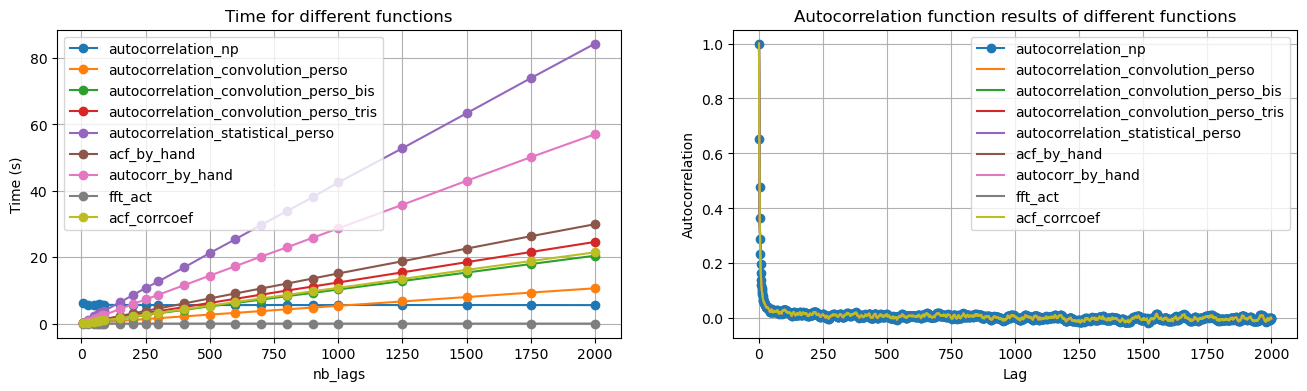

In [63]:
def compare_function(functions, signs, lags, labels, verbose=False):
    assert(len(functions) == len(labels))

    fig, axe = plt.subplots(1, 2, figsize=(16, 4))
    x = []
    last_res = []
    times = [[] for _ in range(len(functions))]
    for k in range(len(lags)):
        nb_lags = lags[k]
        x.append(nb_lags)
        if (verbose):
            print(f"{nb_lags} lags")
        for i, (function, label) in enumerate(zip(functions, labels)):
            s = time.time()
            res = function(signs, nb_lags)
            e = time.time()
            times[i].append(np.round(e - s, 3))
            if (verbose):
                print(f"    {label}: {times[i][-1]} s ({list(res[:3])})")
            if (k == len(lags) - 1):
                last_res.append(res)

        if (verbose):
            print()

    for i in range(len(functions)):
        axe[0].plot(x, times[i], "-o", label=labels[i])
        if (i == 0):
            axe[1].plot(last_res[i], "-o", label=labels[i])
        else:
            axe[1].plot(last_res[i], "-", label=labels[i])

    axe[0].set_title("Time for different functions")
    axe[0].set_xlabel("nb_lags")
    axe[0].set_ylabel("Time (s)")
    axe[0].grid(True)
    axe[0].legend()

    axe[1].set_title("Autocorrelation function results of different functions")
    axe[1].set_xlabel("Lag")
    axe[1].set_ylabel("Autocorrelation")
    axe[1].grid(True)
    axe[1].legend()

    plt.show()

functions = [autocorrelation_np,
             autocorrelation_convolution_perso,
             autocorrelation_convolution_perso_bis,
             autocorrelation_convolution_perso_tris,
             autocorrelation_statistical_perso,
             acf_by_hand,
             autocorr_by_hand,
             fft_act,
             acf_corrcoef
             ]
lags = [5, 25, 50, 60, 70, 80, 90, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]
labels = ["autocorrelation_np",
          "autocorrelation_convolution_perso",
          "autocorrelation_convolution_perso_bis",
          "autocorrelation_convolution_perso_tris",
          "autocorrelation_statistical_perso",
          "acf_by_hand",
          "autocorr_by_hand",
          "fft_act",
          "acf_corrcoef"
          ]
compare_function(functions, signs, lags, labels, verbose=True)


In [18]:
def replace_negative_values_with(values, replacement_value):
    for i in range(len(values)):
        if (values[i] < 0):
            values[i] = replacement_value
    return values

def K(l, gamma=2.1):
    if (l == 0):
        return 1
    assert(l >= 1)
    return l ** (-1.82)



def plot_autocorrelation_training_and_simulated_signs(training_signs, simulated_signs, nb_lags=None, trained_until_lag=None, mode="full"):
    fig, axe = plt.subplots(1, 2, figsize=(18, 4))
    autocorrelation_training, autocorrelation_simulated = None, None
    if (nb_lags is None):
        autocorrelation_training = autocorrelation_calculator.autocorrelation_convolution(training_signs, mode=mode)
        autocorrelation_simulated = autocorrelation_calculator.autocorrelation_convolution(simulated_signs, mode=mode)
    else:
        autocorrelation_training = autocorrelation_calculator.autocorrelation_convolution_perso(training_signs, nb_lags)
        autocorrelation_simulated = autocorrelation_calculator.autocorrelation_convolution_perso(simulated_signs, nb_lags)

    pacf_training = pacf(training_signs, nb_lags)
    pacf_simulated = pacf(simulated_signs, nb_lags)

    axe[0].plot(autocorrelation_training, "black", linestyle="dashed", label=f"Training signs ({len(training_signs)}) autocorrelation function")
    axe[0].plot(autocorrelation_simulated, "blue", label=f"Simulated signs ({len(simulated_signs)}) autocorrelation function")
    # axe[0].plot(pacf_training, "grey", label=f"Training signs PACF ({len(simulated_signs)})")
    # axe[0].plot(pacf_simulated, "red", label=f"Simulated signs PACF ({len(simulated_signs)})")
    axe[0].set_title("Autocorrelation plot for training and simulated signs (linear scale)")
    axe[0].set_xlabel("Lag")
    axe[0].set_ylabel("Autocorrelation")
    axe[0].set_xlim(-5, nb_lags)
    axe[0].set_ylim(min(np.nanmin(autocorrelation_training), np.nanmin(autocorrelation_simulated), np.nanmin(pacf_training), np.nanmin(pacf_simulated)) - 0.1, max(np.nanmax(autocorrelation_training), np.nanmax(autocorrelation_simulated), np.nanmin(pacf_training), np.nanmin(pacf_simulated)) + 0.1)
    axe[0].grid()

    axe[1].plot(autocorrelation_training, "black", linestyle="dashed", label=f"Training signs ({len(training_signs)}) autocorrelation function")
    axe[1].plot(autocorrelation_simulated, "blue", label=f"Simulated signs ({len(simulated_signs)}) autocorrelation function")
    # axe[1].plot(pacf_training, "grey", label=f"Training signs PACF ({len(simulated_signs)})")
    # axe[1].plot(pacf_simulated, "red", label=f"Simulated signs PACF ({len(simulated_signs)})")
    axe[1].set_title("Autocorrelation plot for training and simulated signs (log scale)")
    axe[1].set_xlabel("Lag")
    axe[1].set_ylabel("Autocorrelation")
    axe[1].set_yscale("log")
    axe[1].set_xlim(-5, nb_lags)
    axe[1].set_ylim(max(0.001, min(np.nanmin(autocorrelation_training), np.nanmin(autocorrelation_simulated), np.nanmin(pacf_training), np.nanmin(pacf_simulated)) - 0.1), max(np.nanmax(autocorrelation_training), np.nanmax(autocorrelation_simulated), np.nanmin(pacf_training), np.nanmin(pacf_simulated)) + 0.1)
    axe[1].grid()

    if (trained_until_lag is not None):
        axe[0].axvline(x=trained_until_lag, color='grey', label="Lag until the model has been trained", linestyle='--')
        axe[1].axvline(x=trained_until_lag, color='grey', label="Lag until the model has been trained", linestyle='--')
    
    axe[0].legend()
    axe[1].legend()
  
    plt.show()

def plot_expected_value_details(values, title="Histogram", nb_bins=10):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].hist(values, bins=nb_bins, color='#0504aa', alpha=0.7, rwidth=0.85, density=True)
    axes[0].set_xlim(-1.2, 1.2)
    axes[0].set_xlabel("Expected value")
    axes[0].set_ylabel("Distribution")
    axes[0].set_title(title)

    axes[1].plot(values, color="orange")
    axes[1].set_ylim(-1.2, 1.2)
    axes[1].set_xlabel("Sign number")
    axes[1].set_ylabel("Expected value")
    axes[1].set_title("Expected value evolution")
    plt.show()
    
def f(l, gamma):
    if (l == 0):
        return 1
    return l ** ((gamma - 3) / 2)


<function autocorr_by_hand at 0x14ceb72e0>


In [3]:
signs = sign_extractor.retrieve_signs("APTUSDT", "2023-11-01", "2023-11-01")
# signs = pyspark_utils.get_column_from_pyspark_df(data.filter(F.col("date") == "20231101"), column_name="epsilon", sort_column=["time", "id"])
print(len(signs))
autocorrelation_true = metric_calculator.compute_autocorrelation(signs, 1000)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/04 19:03:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


98019


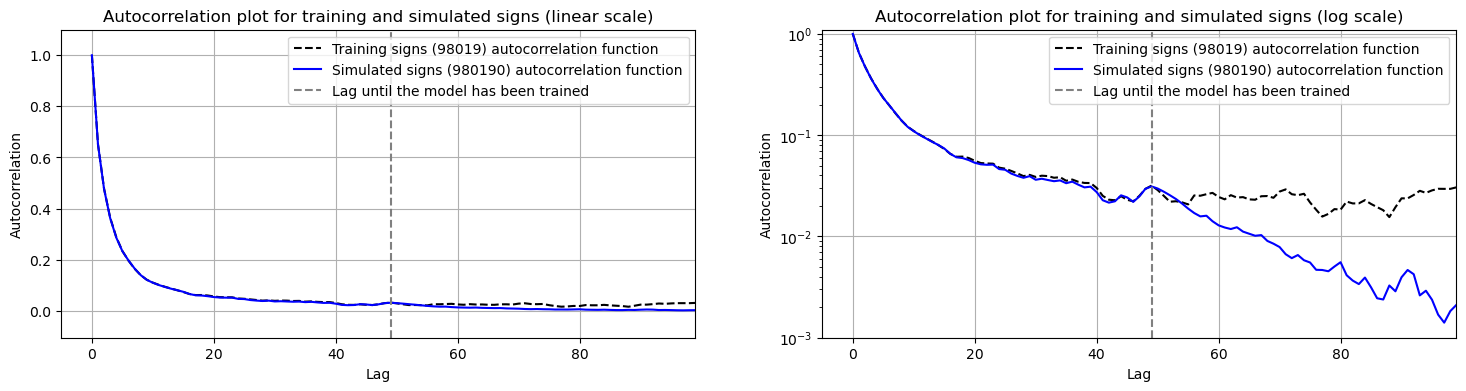

In [5]:
# V2
# Remove negative params? Normalize params? capp if proba_to_buy > 1 or < 0?
from modelisation.models import autoregressive_model
importlib.reload(autoregressive_model)
nb_signs_to_simulate = len(signs) * 10
simulated_signs, nb_lags = autoregressive_model.simulate_signs(signs, nb_lags=49, size=nb_signs_to_simulate)

plot_autocorrelation_training_and_simulated_signs(signs, simulated_signs, nb_lags=nb_lags+50, trained_until_lag=nb_lags)


In [ ]:

consecutives = []
current_sign = signs_filtered[0]
current_consecutive = 1
for sign in signs_filtered[1:]:
    if (sign == current_sign):
        current_consecutive += 1
    else:
        current_sign = sign
        if (current_consecutive > 0):
            consecutives.append(current_consecutive)
        current_consecutive = 1
    
print(consecutives)
# plt.hist(consecutives, bins=50, density=True)
# plt.plot(sorted(consecutives))
print(sum([1 for nb in consecutives if nb>5])/len(consecutives))

[1, 13, 1, 1, 1, 11, 1, 16, 21, 1, 4, 13, 2, 3, 1, 4, 4, 6, 6, 2, 1, 28, 19, 2, 1, 3, 12, 1, 18, 27, 4, 27, 21, 1, 9, 10, 19, 10, 6, 1, 1, 8, 9, 6, 2, 6, 11, 1, 1, 2, 15, 5, 6, 12, 3, 2, 15, 14, 9, 7, 5, 8, 8, 9, 9, 1, 5, 1, 3, 4, 11, 1, 1, 2, 2, 3, 30, 1, 3, 20, 1, 3, 4, 1, 4, 2, 5, 30, 7, 1, 1, 1, 1, 2, 1, 5, 2, 8, 5, 1, 10, 1, 1, 8, 10, 4, 9, 13, 25, 7, 60, 9, 4, 1, 2, 1, 4, 2, 4, 1, 13, 13, 4, 2, 53, 5, 4, 12, 9, 6, 13, 1, 5, 2, 4, 1, 2, 2, 14, 2, 2, 12, 19, 2, 7, 10, 5, 10, 1, 5, 8, 5, 11, 2, 4, 15, 3, 1, 8, 6, 32, 1, 16, 8, 1, 4, 1, 1, 2, 1, 1, 1, 10, 2, 5, 2, 1, 11, 12, 1, 5, 1, 4, 4, 5, 11, 16, 1, 15, 8, 2, 1, 18, 1, 19, 3, 6, 2, 2, 2, 2, 1, 1, 5, 11, 2, 1, 1, 5, 2, 13, 2, 15, 1, 14, 7, 2, 1, 28, 1, 4, 1, 9, 4, 6, 1, 1, 16, 2, 2, 1, 15, 3, 4, 3, 2, 16, 2, 8, 1, 1, 1, 9, 1, 5, 1, 3, 5, 18, 1, 2, 6, 2, 1, 1, 2, 1, 1, 5, 1, 4, 2, 23, 2, 3, 3, 8, 3, 2, 1, 44, 3, 7, 10, 2, 1, 21, 2, 55, 12, 1, 5, 4, 13, 1, 2, 1, 5, 19, 6, 11, 1, 1, 1, 10, 5, 3, 16, 1, 1, 39, 1, 1, 2, 6, 19, 2, 2, 1,

In [ ]:
times = []
lags = []

nb_loops = 10
print(len(signs_1))
importlib.reload(ar_model)
increment_of = len(signs_1) // nb_loops
i_start = 0
i_end = increment_of
current_loop = 1
while (current_loop <= nb_loops):
    signs_ = signs_1[i_start:i_end]
    # print(f"{current_loop} | {i_start} => {i_end} ({len(signs_)} signs)")

    s = time.time()
    mod = ar_model.ar_select_order(signs_, maxlag=100, ic="aic", trend="c")
    e = time.time()
    print(f"{current_loop} | {len(signs_)} signs => {len(mod.ar_lags)} lags | {round(e-s, 3)} s")

    times.append(e-s)
    lags.append(mod.ar_lags)

    if (current_loop < nb_loops - 1):
        i_end += increment_of
    else:
        i_end = len(signs_1)
    current_loop += 1



517837
1 | 0 => 51783 (51783 signs)
51783 signs => 36 lags | 53.437 s
2 | 0 => 103566 (103566 signs)
103566 signs => 57 lags | 100.703 s
3 | 0 => 155349 (155349 signs)
155349 signs => 57 lags | 128.303 s
4 | 0 => 207132 (207132 signs)
207132 signs => 57 lags | 400.092 s
5 | 0 => 258915 (258915 signs)
258915 signs => 58 lags | 208.593 s
6 | 0 => 310698 (310698 signs)
310698 signs => 60 lags | 306.537 s
7 | 0 => 362481 (362481 signs)
362481 signs => 98 lags | 346.206 s
8 | 0 => 414264 (414264 signs)
414264 signs => 98 lags | 342.764 s
9 | 0 => 466047 (466047 signs)
466047 signs => 98 lags | 2373.224 s
10 | 0 => 517837 (517837 signs)
517837 signs => 93 lags | 411.586 s


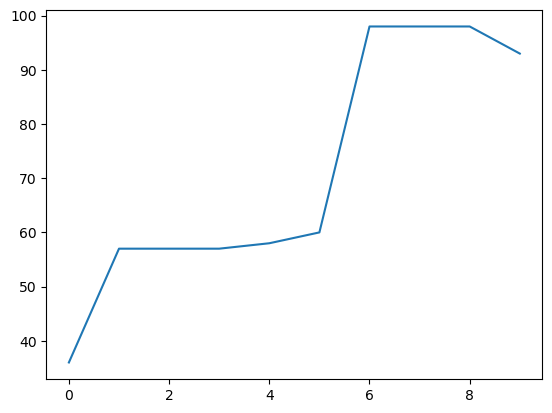

In [ ]:
# plt.plot(range(1, len(times) + 1), times)
nb_lags_ = [len(lag) for lag in lags]
nb_lags_
plt.plot(nb_lags_)

In [ ]:
# # nb_lags_candidates = [range(10, 201, 10)] + [range(300, 501, 100)]
# nb_lags_candidates = [nb_lags for nb_lags in range(10, 201, 10)] + [lags for lags in range(300, 1001, 100)]
# # nb_lags_candidates = [10, 20]
# print(len(nb_lags_candidates), nb_lags_candidates)
# nb_signs_to_simulate = len(signs_1)
# p = 1

# metric_results = pd.DataFrame(columns=["nb_lags","metric_buy_pct", "metric_std_buy_pct", "metric_mae_autocorrelation", "time_all_process", "time_model_fit", "time_sign_simulation"])
# for nb_lags in nb_lags_candidates:
#     print(f"Current nb_lags: {nb_lags}")
#     metric_buy_pct, metric_std_buy_pct, metric_mae_autocorrelation, time_all_process, time_model_fit, time_sign_simulation = generate_n_future_signs_V2(autocorrelation_true, signs_1, nb_signs_to_simulate, nb_lags, p, include_cst_param=True)
#     metric_results.loc[len(metric_results.index)] = [nb_lags, metric_buy_pct, metric_std_buy_pct, metric_mae_autocorrelation, time_all_process, time_model_fit, time_sign_simulation]

# metric_results["nb_lags"] = metric_results["nb_lags"].astype("int")
# display(metric_results)
# metric_results.to_excel("/Users/martingangand/Documents/trade_flow_modelling/metric_results/metric_results_different_nb_lags.xlsx")

In [ ]:
importlib.reload(sign_simulator)
sign_simulator.select_appropriate_nb_lags(signs_filtered)

49

In [ ]:
int(np.ceil(12.0 * np.power(1000000 / 100.0, 1 / 4.0)))

120

In [ ]:
import statsmodels.tsa.stattools as stattools
importlib.reload(stattools)
from typing import Literal

X = signs_filtered



print(is_time_series_stationary(X, verbose=True))

Test Statistic: -31.816876336055586
p-value: 0.0
#Lags Used: 72
Number of Observations Used: 125546
Critical Value (1%%): -3.4304020879495085
Critical Value (5%%): -2.861563022109245
Critical Value (10%%): -2.5667822538541594
True


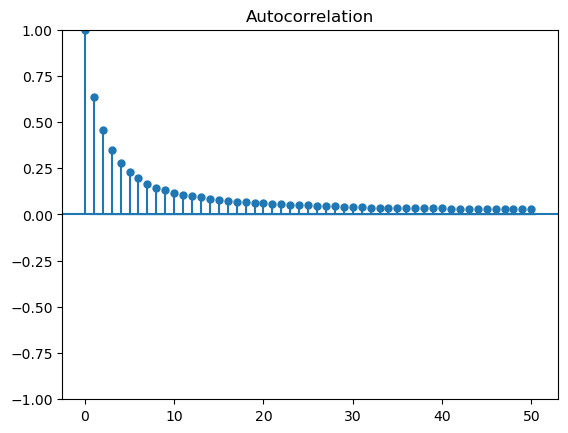

In [42]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
# pacf = plot_pacf(signs_test, lags=50)
acf = plot_acf(signs, lags=50)

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
ar_model = AutoReg(signs_test, lags=125).fit()
#
# Print Summary
#
# print(ar_model.summary())
coeffs = ar_model.params[1:]
print(len(coeffs), sum(coeffs))
print(coeffs[:10])
# plt.plot(coeffs)


125 0.9441001437863615
[0.31204807 0.14108772 0.08984722 0.06251513 0.04792222 0.03515184
 0.03077804 0.02621214 0.01825998 0.02001144]


In [ ]:
print(sum(ar_model.bse))

0.21141314609300924


0.8705
-0.7815999999999999
========================== START (, 500000 signs) ==========================
Buy: 236878 (47.376%) | Sell 263122 (52.624%)
Portions of 50000 => [52.18% (50000) | 49.06% (50000) | 47.52% (50000) | 48.35% (50000) | 47.58% (50000) | 37.95% (50000) | 51.63% (50000) | 42.36% (50000) | 46.05% (50000) | 51.07% (50000)]
========================== END (, 500000 signs) ==========================

-0.05254363430816333


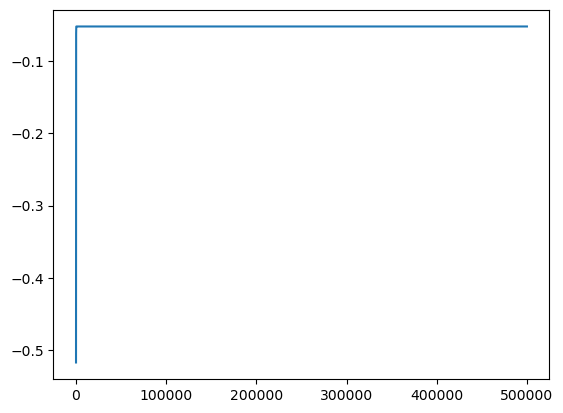

In [ ]:
a = [0.2690, 0.1425, 0.0964, 0.0758, 0.0553, 0.0512, 0.0571, 0.0334, 0.0394, 0.0504]
b = [1.0363, 1.0402,1.0402, 0.4044,0.4044, -0.4457, -0.4457, -1.1777 , -1.1777 , -1.4603]
print(sum(a))
print(sum(b))
pred = ar_model.predict(start=len(signs_test), end=len(signs_test) * 2, dynamic=False)
print_signs_info(signs_test, "")
plt.plot(pred)
print(pred[1000])

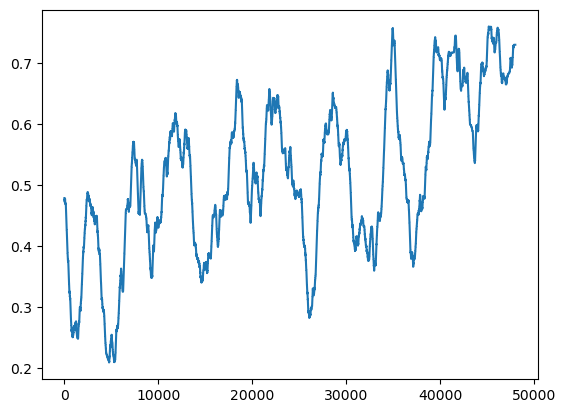

In [ ]:
values = []
def buy_percentage(signs):
    return np.sum([1 for sign in signs if sign == 1]) / len(signs)

l = 2000
for i in range(l, len(signs_test)):
    values.append(buy_percentage(signs_test[i-l:i]))
    # values.append(np.mean(signs_test[i-l:i]))
plt.plot(values)

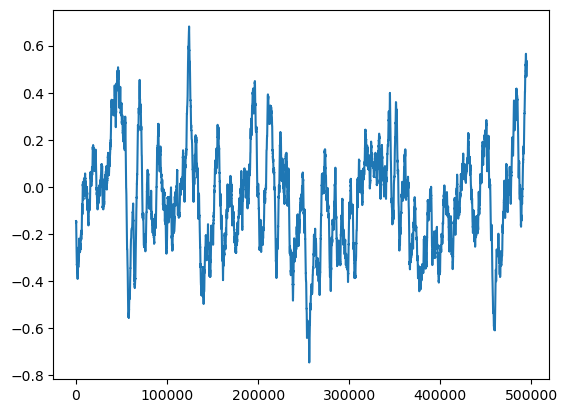

In [ ]:
signs_test = signs[:500000]
values = []
l = 5000
for i in range(l, len(signs_test)):
    values.append(np.mean(signs_test[i-l:i]))
plt.plot(values)

In [ ]:
def autocorrelation_statistical(x, length=20):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1]  \
        for i in range(1, length)])
print(autocorrelation_statistical(signs_test))

[1.         0.59084605 0.53501419 0.46604099 0.49977718 0.48305675
 0.50498983 0.45317801 0.41039251 0.40268901 0.38569504 0.40761022
 0.35510937 0.35838048 0.34119561 0.35381085 0.34125136 0.33510839
 0.29424418 0.30212177]


In [32]:
import statsmodels.tsa.api as smt
smt.acovf(signs)[:10]

array([0.99999913, 0.63316425, 0.45564087, 0.34743652, 0.27736922,
       0.22877432, 0.19516673, 0.16747309, 0.14512949, 0.12975537])

276634
The Autocorrelation plot for the data is:


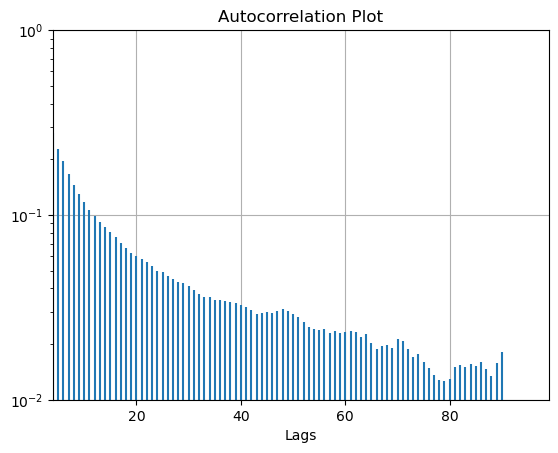

In [43]:
# Adding plot title.
plt.title("Autocorrelation Plot") 
print(len(signs))
# Providing x-axis name.
plt.xlabel("Lags") 
s = [float(i) for i in signs]
# Plotting the Autocorrelation plot.
plt.acorr(s, maxlags = 90) 

# Displaying the plot.
print("The Autocorrelation plot for the data is:")
plt.yscale("log")
plt.grid(True)
plt.xlim(left=4)
plt.ylim(0.01, 1)
plt.show()

In [ ]:
def order_sign_imbalance(signs):
    return np.sum(signs) / len(signs)